In [2]:
"""
Preprocess all the training data.
Builds a vocabulary and converts all sentences into numerical indices
"""

import os
from glob import glob
from collections import Counter
import pickle
import numpy as np

DATA_DIR = os.environ.get("P4_DATA_ROOT", "data/")


def read_labeled_sentences(f):
    out = []
    for line in f:
        line = line.strip()
        label, sent = line.split("\t")
        words = sent.split()
        bool_label = label == 'POS'
        out.append((bool_label, words))
    return out


def read_unlabeled_sentences(f):
    out = []
    for line in f:
        line = line.strip()
        words = line.split()
        out.append(words)
    return out


if __name__ == '__main__':

    with open(os.path.join(DATA_DIR, "train.txt")) as f:
        train_sents = read_labeled_sentences(f)

    with open(os.path.join(DATA_DIR, "valid.txt")) as f:
        valid_sents = read_labeled_sentences(f)

    with open(os.path.join(DATA_DIR, "test.txt")) as f:
        test_sents = read_labeled_sentences(f)

    with open(os.path.join(DATA_DIR, "unlabeled.txt")) as f:
        unlabeled_sents = read_unlabeled_sentences(f)


    # establish the vocabulary
    ##########################

    # start with list of most common words, labeled or unlabeled
    word_counter = Counter(w for _, sent in train_sents for w in sent)
    word_counter.update(w for sent in unlabeled_sents for w in sent)

    # toss words that don't appear at least 10 times
    vocab = [w for w, _ in word_counter.most_common()
             if word_counter[w] >= 10]

    # add special tokens
    unk = '__UNK__'
    s_start = '__START__'
    s_end = '__END__'
    vocab = [unk, s_start, s_end] + vocab

    # build inverse vocabulary
    # i.e. if vocab[17] = 'cat', then inv_vocab['cat'] = 17
    inv_vocab = {w: k for k, w in enumerate(vocab)}

    def sentence_to_ix(sent):
        sent = [s_start] + sent + [s_end]
        sent_ix = [inv_vocab.get(w, inv_vocab[unk])
                   for w in sent]
        return sent_ix

    # vectorize and save sentence as lists of ids
    #############################################

    train_ix = [(y, sentence_to_ix(sent)) for y, sent in train_sents]
    valid_ix = [(y, sentence_to_ix(sent)) for y, sent in valid_sents]
    test_ix = [(y, sentence_to_ix(sent)) for y, sent in test_sents]
    unlab_ix = [(None, sentence_to_ix(sent)) for sent in unlabeled_sents]

    if not os.path.exists("processed"):
        os.makedirs("processed")

    with open(os.path.join("processed", "vocab.txt"), "w") as f:
        for w in vocab:
            print(w, file=f)

    with open(os.path.join("processed", "train_ix.pkl"), "wb") as f:
        pickle.dump(train_ix, f)

    with open(os.path.join("processed", "unlab_ix.pkl"), "wb") as f:
        pickle.dump(unlab_ix, f)

    with open(os.path.join("processed", "valid_ix.pkl"), "wb") as f:
        pickle.dump(valid_ix, f)

    with open(os.path.join("processed", "test_ix.pkl"), "wb") as f:
        pickle.dump(test_ix, f)


In [3]:
# Task 1
print(len(vocab))

4748


In [6]:
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))

        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))

    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:

            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas

    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))


Epoch   0 took 1.3s. Train loss:  0.68095 Valid accuracy:    58.31
Epoch   1 took 1.7s. Train loss:  0.64478 Valid accuracy:    59.21
Epoch   2 took 1.9s. Train loss:  0.60173 Valid accuracy:    59.64
Epoch   3 took 1.4s. Train loss:  0.56313 Valid accuracy:    59.74
Epoch   4 took 1.4s. Train loss:  0.53092 Valid accuracy:    59.69
Epoch   5 took 1.4s. Train loss:  0.50447 Valid accuracy:    59.69
Epoch   6 took 1.3s. Train loss:  0.48258 Valid accuracy:    59.57
Epoch   7 took 1.4s. Train loss:  0.46429 Valid accuracy:    59.49
Epoch   8 took 1.3s. Train loss:  0.44882 Valid accuracy:    59.22
Epoch   9 took 1.5s. Train loss:  0.43569 Valid accuracy:    58.79
Epoch  10 took 1.4s. Train loss:  0.42457 Valid accuracy:    58.59
Epoch  11 took 1.3s. Train loss:  0.41507 Valid accuracy:    58.45
Epoch  12 took 1.4s. Train loss:  0.40677 Valid accuracy:    58.26
Epoch  13 took 1.3s. Train loss:  0.39937 Valid accuracy:    58.17
Epoch  14 took 1.5s. Train loss:  0.39268 Valid accuracy:    5

In [23]:
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))

        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))

    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas

    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))

Epoch   0 took 2.1s. Train loss:  0.69038 Valid accuracy:    56.81
Epoch   1 took 2.1s. Train loss:  0.66849 Valid accuracy:    58.48
Epoch   2 took 2.2s. Train loss:  0.64671 Valid accuracy:    59.67
Epoch   3 took 2.1s. Train loss:  0.62248 Valid accuracy:    60.22
Epoch   4 took 2.1s. Train loss:  0.60132 Valid accuracy:    60.17
Epoch   5 took 2.1s. Train loss:  0.58470 Valid accuracy:    59.87
Epoch   6 took 1.9s. Train loss:  0.56936 Valid accuracy:    60.00
Epoch   7 took 2.1s. Train loss:  0.55259 Valid accuracy:    60.61
Epoch   8 took 2.1s. Train loss:  0.54465 Valid accuracy:    60.65
Epoch   9 took 2.0s. Train loss:  0.52997 Valid accuracy:    60.72
Epoch  10 took 2.3s. Train loss:  0.51847 Valid accuracy:    60.41
Epoch  11 took 2.3s. Train loss:  0.51202 Valid accuracy:    60.66
Epoch  12 took 2.2s. Train loss:  0.49826 Valid accuracy:    60.22
Epoch  13 took 1.9s. Train loss:  0.49302 Valid accuracy:    60.83
Epoch  14 took 1.8s. Train loss:  0.49155 Valid accuracy:    6

In [92]:
"""Simplest possible neural language model:
    use word w_i to predict word w_(i + 1)
"""
import os
import pickle
from time import clock
from math import exp

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
USE_UNLABELED = False
VOCAB_SIZE = len(vocab)#__FIXME__
valid_perplexity_labeled_bigram = []

def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class SimpleNLM(object):

    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))

        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.W_out = params.add_parameters((vocab_size, hidden_dim))

    def batch_loss(self, batch, train=True):

        # load the parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)

        W_out = dy.parameter(self.W_out)

        losses = []
        for _, sent in batch:
            for i in range(1, len(sent)):
                prev_word_ix = sent[i - 1]
                curr_word_ix = sent[i]

                ctx = dy.lookup(self.embed, prev_word_ix)

                # hid is the hidden layer output, size=hidden_size
                # compute b_hid + W_hid * ctx, but faster
                hid = dy.affine_transform([b_hid, W_hid, ctx])
                hid = dy.tanh(hid)

                # out is the prediction of the next word, size=vocab_size
                out = W_out * hid

                # Intepretation: The model estimates that
                # log P(curr_word=k | prev_word) ~ out[k]
                # in other words,
                # P(curr_word=k | prev_word) = exp(out[k]) / sum_j exp(out[j])
                #                            = softmax(out)[k]

                # We want to maximize the probability of the correct word.
                # (equivalently, minimize the negative log-probability)

                loss = dy.pickneglogsoftmax(out, curr_word_ix)
                losses.append(loss)

        # esum simply adds up the expressions in the list
        return dy.esum(losses)


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    if USE_UNLABELED:
        __FIXME__

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()
        
        # Task 4
        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_labeled_bigram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")


Epoch   0 took 25.8s. Train perplexity:  239.070 Valid perplexity:  140.395
Epoch   1 took 26.0s. Train perplexity:  137.390 Valid perplexity:  121.028
Epoch   2 took 26.3s. Train perplexity:  120.594 Valid perplexity:  112.584
Epoch   3 took 26.2s. Train perplexity:  111.206 Valid perplexity:  107.999
Epoch   4 took 25.6s. Train perplexity:  105.055 Valid perplexity:  105.082
Epoch   5 took 26.3s. Train perplexity:  100.566 Valid perplexity:  103.089
Epoch   6 took 24.5s. Train perplexity:   97.064 Valid perplexity:  101.645
Epoch   7 took 26.4s. Train perplexity:   94.201 Valid perplexity:  100.564
Epoch   8 took 24.9s. Train perplexity:   91.791 Valid perplexity:   99.740
Epoch   9 took 25.2s. Train perplexity:   89.724 Valid perplexity:   99.098
Epoch  10 took 25.7s. Train perplexity:   87.926 Valid perplexity:   98.596
Epoch  11 took 26.7s. Train perplexity:   86.341 Valid perplexity:   98.203
Epoch  12 took 25.4s. Train perplexity:   84.926 Valid perplexity:   97.898
Epoch  13 to

In [93]:
"""Simplest possible neural language model:
    use word w_i to predict word w_(i + 1)
"""
import os
import pickle
from time import clock
from math import exp

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
USE_UNLABELED = True
VOCAB_SIZE = len(vocab) #__FIXME__
valid_perplexity_all_bigram = []

def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class SimpleNLM(object):

    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))

        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.W_out = params.add_parameters((vocab_size, hidden_dim))

    def batch_loss(self, batch, train=True):

        # load the parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)

        W_out = dy.parameter(self.W_out)

        losses = []
        for _, sent in batch:
            for i in range(1, len(sent)):
                prev_word_ix = sent[i - 1]
                curr_word_ix = sent[i]

                ctx = dy.lookup(self.embed, prev_word_ix)

                # hid is the hidden layer output, size=hidden_size
                # compute b_hid + W_hid * ctx, but faster
                hid = dy.affine_transform([b_hid, W_hid, ctx])
                hid = dy.tanh(hid)

                # out is the prediction of the next word, size=vocab_size
                out = W_out * hid

                # Intepretation: The model estimates that
                # log P(curr_word=k | prev_word) ~ out[k]
                # in other words,
                # P(curr_word=k | prev_word) = exp(out[k]) / sum_j exp(out[j])
                #                            = softmax(out)[k]

                # We want to maximize the probability of the correct word.
                # (equivalently, minimize the negative log-probability)

                loss = dy.pickneglogsoftmax(out, curr_word_ix)
                losses.append(loss)

        # esum simply adds up the expressions in the list
        return dy.esum(losses)


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)
    if USE_UNLABELED:
        #__FIXME__
        with open(os.path.join('processed', 'unlab_ix.pkl'), 'rb') as f:
            train_ix += pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_all_bigram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")


Epoch   0 took 45.1s. Train perplexity:  167.268 Valid perplexity:  114.813
Epoch   1 took 45.4s. Train perplexity:  114.421 Valid perplexity:  103.108
Epoch   2 took 45.8s. Train perplexity:  104.174 Valid perplexity:   98.189
Epoch   3 took 44.7s. Train perplexity:   98.539 Valid perplexity:   95.357
Epoch   4 took 47.2s. Train perplexity:   94.822 Valid perplexity:   93.558
Epoch   5 took 43.0s. Train perplexity:   92.155 Valid perplexity:   92.301
Epoch   6 took 44.6s. Train perplexity:   90.113 Valid perplexity:   91.373
Epoch   7 took 42.5s. Train perplexity:   88.486 Valid perplexity:   90.674
Epoch   8 took 45.6s. Train perplexity:   87.146 Valid perplexity:   90.133
Epoch   9 took 45.4s. Train perplexity:   86.009 Valid perplexity:   89.704
Epoch  10 took 45.2s. Train perplexity:   85.034 Valid perplexity:   89.362
Epoch  11 took 43.6s. Train perplexity:   84.192 Valid perplexity:   89.088
Epoch  12 took 44.5s. Train perplexity:   83.455 Valid perplexity:   88.872
Epoch  13 to

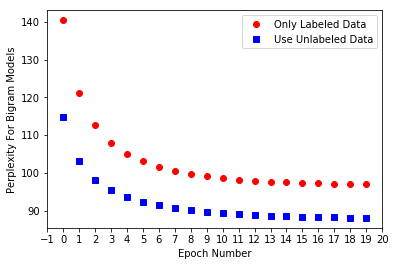

In [98]:
# Task 5
import matplotlib.pyplot as plt
plt.plot(valid_perplexity_labeled_bigram, 'ro', label='Only Labeled Data')
plt.plot(valid_perplexity_all_bigram, 'bs', label='Use Unlabeled Data')
plt.ylabel('Perplexity For Bigram Models')
plt.xlabel('Epoch Number')
plt.legend()
plt.xticks(range(-1, 21))
plt.show()

In [84]:
# Task 6 trigrams
"""Simplest possible neural language model:
    use word w_i to predict word w_(i + 1)
"""
import os
import pickle
from time import clock
from math import exp

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
USE_UNLABELED = False
VOCAB_SIZE = len(vocab) #__FIXME__
valid_perplexity_labeled_trigram = []
valid_perplexity__trigram = []

def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class SimpleNLM(object):

    def __init__(self, n, params, vocab_size, hidden_dim):
        self.ngram = n
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim * (n - 1)

        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))

        self.W_hid = params.add_parameters((hidden_dim, hidden_dim * (n - 1)))
        self.b_hid = params.add_parameters((hidden_dim))

        self.W_out = params.add_parameters((vocab_size, hidden_dim))
    
    def batch_loss(self, batch, train=True):

        # load the parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)

        W_out = dy.parameter(self.W_out)
        n = self.ngram
        
        losses = []
        for _, sent in batch:
            for i in range(n - 1, len(sent)):
                #prev_word_ix = [] # Task 6: ck is with dimension n x (k - 1)
                ctx = []
                for j in range(i - n + 1, i):
                    prev_word_ix = sent[j]
                    ctx.append(dy.lookup(self.embed, prev_word_ix))
                curr_word_ix = sent[i]
                
                ctx = dy.concatenate(ctx)
                #ctx = dy.lookup(self.embed, prev_word_ix)

                # hid is the hidden layer output, size=hidden_size
                # compute b_hid + W_hid * ctx, but faster
                hid = dy.affine_transform([b_hid, W_hid, ctx])
                hid = dy.tanh(hid)

                # out is the prediction of the next word, size=vocab_size
                out = W_out * hid

                # Intepretation: The model estimates that
                # log P(curr_word=k | prev_word) ~ out[k]
                # in other words,
                # P(curr_word=k | prev_word) = exp(out[k]) / sum_j exp(out[j])
                #                            = softmax(out)[k]

                # We want to maximize the probability of the correct word.
                # (equivalently, minimize the negative log-probability)

                loss = dy.pickneglogsoftmax(out, curr_word_ix)
                losses.append(loss)

        # esum simply adds up the expressions in the list
        return dy.esum(losses)

if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)
    if USE_UNLABELED:
        #__FIXME__
        with open(os.path.join('processed', 'unlab_ix.pkl'), 'rb') as f:
            train_ix += pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(3, params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_labeled_trigram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm_trigram"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")

Epoch   0 took 28.1s. Train perplexity:  195.445 Valid perplexity:  123.347
Epoch   1 took 27.0s. Train perplexity:  118.824 Valid perplexity:  102.882
Epoch   2 took 28.7s. Train perplexity:  101.632 Valid perplexity:   92.863
Epoch   3 took 28.5s. Train perplexity:   91.366 Valid perplexity:   87.075
Epoch   4 took 28.1s. Train perplexity:   84.504 Valid perplexity:   83.420
Epoch   5 took 28.1s. Train perplexity:   79.498 Valid perplexity:   80.935
Epoch   6 took 29.0s. Train perplexity:   75.588 Valid perplexity:   79.185
Epoch   7 took 27.1s. Train perplexity:   72.405 Valid perplexity:   77.916
Epoch   8 took 28.3s. Train perplexity:   69.737 Valid perplexity:   76.984
Epoch   9 took 28.6s. Train perplexity:   67.458 Valid perplexity:   76.301
Epoch  10 took 28.4s. Train perplexity:   65.473 Valid perplexity:   75.803
Epoch  11 took 28.4s. Train perplexity:   63.712 Valid perplexity:   75.446
Epoch  12 took 29.0s. Train perplexity:   62.130 Valid perplexity:   75.202
Epoch  13 to

In [85]:
# Task 6 trigrams with unlabeled data

USE_UNLABELED = True
valid_perplexity_all_trigram = []

if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)
    if USE_UNLABELED:
        #__FIXME__
        with open(os.path.join('processed', 'unlab_ix.pkl'), 'rb') as f:
            train_ix += pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(3, params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_all_trigram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm_trigram"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")

Epoch   0 took 48.3s. Train perplexity:  138.406 Valid perplexity:   94.633
Epoch   1 took 45.4s. Train perplexity:   92.042 Valid perplexity:   81.580
Epoch   2 took 46.8s. Train perplexity:   81.031 Valid perplexity:   75.734
Epoch   3 took 47.8s. Train perplexity:   74.982 Valid perplexity:   72.534
Epoch   4 took 47.9s. Train perplexity:   71.031 Valid perplexity:   70.519
Epoch   5 took 46.2s. Train perplexity:   68.198 Valid perplexity:   69.178
Epoch   6 took 44.9s. Train perplexity:   66.039 Valid perplexity:   68.230
Epoch   7 took 47.5s. Train perplexity:   64.305 Valid perplexity:   67.540
Epoch   8 took 46.9s. Train perplexity:   62.868 Valid perplexity:   67.030
Epoch   9 took 47.6s. Train perplexity:   61.647 Valid perplexity:   66.653
Epoch  10 took 47.3s. Train perplexity:   60.594 Valid perplexity:   66.373
Epoch  11 took 46.5s. Train perplexity:   59.671 Valid perplexity:   66.163
Epoch  12 took 43.9s. Train perplexity:   58.854 Valid perplexity:   66.017
Epoch  13 to

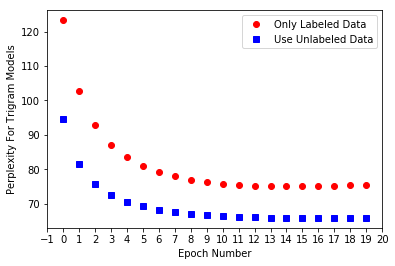

In [99]:
# Task 6 trigram graph
import matplotlib.pyplot as plt
plt.plot(valid_perplexity_labeled_trigram, 'ro', label='Only Labeled Data')
plt.plot(valid_perplexity_all_trigram, 'bs', label='Use Unlabeled Data')
plt.ylabel('Perplexity For Trigram Models')
plt.xlabel('Epoch Number')
plt.legend()
plt.xticks(range(-1, 21))
plt.show()

In [89]:
# Task 6 4-grams

USE_UNLABELED = False
valid_perplexity_labeled_4gram = []

if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)
    if USE_UNLABELED:
        #__FIXME__
        with open(os.path.join('processed', 'unlab_ix.pkl'), 'rb') as f:
            train_ix += pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(4, params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_labeled_4gram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm_4gram"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")

Epoch   0 took 28.3s. Train perplexity:  163.895 Valid perplexity:  105.243
Epoch   1 took 29.9s. Train perplexity:  100.772 Valid perplexity:   87.161
Epoch   2 took 28.8s. Train perplexity:   86.746 Valid perplexity:   79.503
Epoch   3 took 26.4s. Train perplexity:   78.989 Valid perplexity:   74.650
Epoch   4 took 29.5s. Train perplexity:   73.637 Valid perplexity:   71.503
Epoch   5 took 31.3s. Train perplexity:   69.675 Valid perplexity:   69.259
Epoch   6 took 29.1s. Train perplexity:   66.397 Valid perplexity:   67.508
Epoch   7 took 27.9s. Train perplexity:   63.626 Valid perplexity:   66.176
Epoch   8 took 27.5s. Train perplexity:   61.234 Valid perplexity:   65.124
Epoch   9 took 27.1s. Train perplexity:   59.096 Valid perplexity:   64.282
Epoch  10 took 27.8s. Train perplexity:   57.218 Valid perplexity:   63.666
Epoch  11 took 27.7s. Train perplexity:   55.552 Valid perplexity:   63.207
Epoch  12 took 27.8s. Train perplexity:   54.048 Valid perplexity:   62.888
Epoch  13 to

In [90]:
# Task 6 trigrams with unlabeled

USE_UNLABELED = True
valid_perplexity_all_4gram = []

if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)
    if USE_UNLABELED:
        #__FIXME__
        with open(os.path.join('processed', 'unlab_ix.pkl'), 'rb') as f:
            train_ix += pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    lm = SimpleNLM(4, params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, batch_size=BATCH_SIZE)
    valid_batches = make_batches(valid_ix, batch_size=BATCH_SIZE)

    n_train_words = sum(len(sent) for _, sent in train_ix)
    n_valid_words = sum(len(sent) for _, sent in valid_ix)

    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate loss.
        valid_loss = 0
        for batch in valid_batches:
            dy.renew_cg()
            loss = lm.batch_loss(batch, train=False)
            valid_loss += loss.value()

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train perplexity: {:8.3f} "
               "Valid perplexity: {:8.3f}").format(
            it,
            toc - tic,
            exp(total_loss / n_train_words),
            exp(valid_loss / n_valid_words)
            ))
        valid_perplexity_all_4gram.append(exp(valid_loss / n_valid_words))
        
    # FIXME: make sure to update filenames when implementing ngram models
    fn = "embeds_baseline_lm_4gram"
    if USE_UNLABELED:
        fn += "_unlabeled"

    print("Saving embeddings to {}".format(fn))
    lm.embed.save(fn, "/embed")

Epoch   0 took 47.4s. Train perplexity:  118.949 Valid perplexity:   82.677
Epoch   1 took 44.1s. Train perplexity:   79.539 Valid perplexity:   70.120
Epoch   2 took 48.1s. Train perplexity:   69.642 Valid perplexity:   64.678
Epoch   3 took 47.4s. Train perplexity:   64.041 Valid perplexity:   61.412
Epoch   4 took 46.9s. Train perplexity:   60.281 Valid perplexity:   59.320
Epoch   5 took 48.4s. Train perplexity:   57.549 Valid perplexity:   57.936
Epoch   6 took 47.8s. Train perplexity:   55.442 Valid perplexity:   56.941
Epoch   7 took 47.5s. Train perplexity:   53.772 Valid perplexity:   56.230
Epoch   8 took 46.9s. Train perplexity:   52.400 Valid perplexity:   55.711
Epoch   9 took 45.3s. Train perplexity:   51.241 Valid perplexity:   55.326
Epoch  10 took 47.6s. Train perplexity:   50.236 Valid perplexity:   55.028
Epoch  11 took 47.7s. Train perplexity:   49.362 Valid perplexity:   54.790
Epoch  12 took 46.3s. Train perplexity:   48.596 Valid perplexity:   54.609
Epoch  13 to

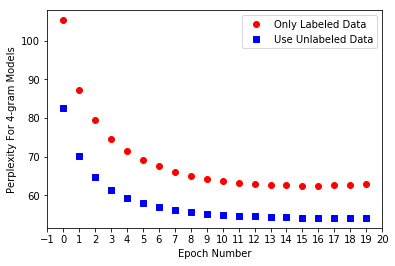

In [100]:
# Task 6 4-grams graph

import matplotlib.pyplot as plt
plt.plot(valid_perplexity_labeled_4gram, 'ro', label='Only Labeled Data')
plt.plot(valid_perplexity_all_4gram, 'bs', label='Use Unlabeled Data')
plt.ylabel('Perplexity For 4-gram Models')
plt.xlabel('Epoch Number')
plt.xticks(range(-1, 21))
plt.legend()
plt.show()

In [24]:
# Task 7 bigram embedding
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 2.1s. Train loss:  0.68899 Valid accuracy:    56.46
Update parameters
Epoch   1 took 2.3s. Train loss:  0.67866 Valid accuracy:    57.22
Update parameters
Epoch   2 took 2.0s. Train loss:  0.67112 Valid accuracy:    58.58
Update parameters
Epoch   3 took 2.0s. Train loss:  0.65927 Valid accuracy:    59.23
Update parameters
Epoch   4 took 2.3s. Train loss:  0.64471 Valid accuracy:    59.85
Update parameters
Epoch   5 took 1.9s. Train loss:  0.63040 Valid accuracy:    60.13
Update parameters
Epoch   6 took 1.8s. Train loss:  0.61786 Valid accuracy:    60.52
Update parameters
Epoch   7 took 1.9s. Train loss:  0.59933 Valid accuracy:    60.67
Update parameters
Epoch   8 took 2.1s. Train loss:  0.59194 Valid accuracy:    61.05
Update parameters
Epoch   9 took 1.8s. Train loss:  0.58187 Valid accuracy:    60.75
Epoch  10 took 2.4s. Train loss:  0.56524 Valid accuracy:    60.97
Epoch  11 took 2.2s. Train loss:  0.55450 Valid accuracy:    60.59
Epoch  12 took 2.0s. Train loss:  

In [25]:
# Task 7 bigram embedding with unlabeled data
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm_unlabeled', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 2.1s. Train loss:  0.69231 Valid accuracy:    56.08
Update parameters
Epoch   1 took 2.2s. Train loss:  0.68133 Valid accuracy:    57.48
Update parameters
Epoch   2 took 2.1s. Train loss:  0.67557 Valid accuracy:    58.16
Update parameters
Epoch   3 took 2.1s. Train loss:  0.66312 Valid accuracy:    59.08
Update parameters
Epoch   4 took 2.4s. Train loss:  0.65330 Valid accuracy:    59.67
Update parameters
Epoch   5 took 2.2s. Train loss:  0.64238 Valid accuracy:    59.98
Update parameters
Epoch   6 took 1.9s. Train loss:  0.63270 Valid accuracy:    60.27
Update parameters
Epoch   7 took 2.0s. Train loss:  0.61879 Valid accuracy:    60.68
Update parameters
Epoch   8 took 2.0s. Train loss:  0.60511 Valid accuracy:    60.46
Epoch   9 took 1.9s. Train loss:  0.59230 Valid accuracy:    60.25
Epoch  10 took 2.0s. Train loss:  0.57991 Valid accuracy:    60.39
Epoch  11 took 2.1s. Train loss:  0.56963 Valid accuracy:    60.55
Epoch  12 took 2.2s. Train loss:  0.55948 Valid accu

In [26]:
# Task 7 trigram embedding
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm_trigram', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 1.9s. Train loss:  0.69132 Valid accuracy:    56.49
Update parameters
Epoch   1 took 2.3s. Train loss:  0.67760 Valid accuracy:    57.43
Update parameters
Epoch   2 took 2.2s. Train loss:  0.66591 Valid accuracy:    58.62
Update parameters
Epoch   3 took 1.9s. Train loss:  0.65026 Valid accuracy:    59.20
Update parameters
Epoch   4 took 2.3s. Train loss:  0.63536 Valid accuracy:    59.89
Update parameters
Epoch   5 took 1.9s. Train loss:  0.62346 Valid accuracy:    60.11
Update parameters
Epoch   6 took 2.0s. Train loss:  0.60871 Valid accuracy:    60.29
Update parameters
Epoch   7 took 2.2s. Train loss:  0.59724 Valid accuracy:    60.52
Update parameters
Epoch   8 took 2.3s. Train loss:  0.58564 Valid accuracy:    60.73
Update parameters
Epoch   9 took 1.8s. Train loss:  0.57325 Valid accuracy:    60.64
Epoch  10 took 2.1s. Train loss:  0.56089 Valid accuracy:    60.67
Epoch  11 took 2.2s. Train loss:  0.55013 Valid accuracy:    60.62
Epoch  12 took 2.0s. Train loss:  

In [27]:
# Task 7 trigram embedding with unlabeled data (best embeddings by validation set?)
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm_trigram_unlabeled', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 2.2s. Train loss:  0.69534 Valid accuracy:    56.86
Update parameters
Epoch   1 took 2.2s. Train loss:  0.67763 Valid accuracy:    57.78
Update parameters
Epoch   2 took 2.0s. Train loss:  0.66758 Valid accuracy:    58.72
Update parameters
Epoch   3 took 2.0s. Train loss:  0.65662 Valid accuracy:    59.58
Update parameters
Epoch   4 took 2.2s. Train loss:  0.64254 Valid accuracy:    59.70
Update parameters
Epoch   5 took 2.1s. Train loss:  0.62767 Valid accuracy:    60.23
Update parameters
Epoch   6 took 2.1s. Train loss:  0.61622 Valid accuracy:    60.48
Update parameters
Epoch   7 took 2.3s. Train loss:  0.59955 Valid accuracy:    60.46
Epoch   8 took 2.2s. Train loss:  0.59491 Valid accuracy:    60.56
Update parameters
Epoch   9 took 1.9s. Train loss:  0.57715 Valid accuracy:    60.74
Update parameters
Epoch  10 took 2.3s. Train loss:  0.56597 Valid accuracy:    60.77
Update parameters
Epoch  11 took 2.2s. Train loss:  0.55669 Valid accuracy:    60.84
Update parameter

In [28]:
# Task 7 4-gram embedding
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm_4gram', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 2.0s. Train loss:  0.69070 Valid accuracy:    56.67
Update parameters
Epoch   1 took 2.1s. Train loss:  0.67834 Valid accuracy:    57.98
Update parameters
Epoch   2 took 2.2s. Train loss:  0.66457 Valid accuracy:    59.01
Update parameters
Epoch   3 took 2.2s. Train loss:  0.64902 Valid accuracy:    59.75
Update parameters
Epoch   4 took 2.2s. Train loss:  0.63394 Valid accuracy:    59.83
Update parameters
Epoch   5 took 2.2s. Train loss:  0.62064 Valid accuracy:    60.17
Update parameters
Epoch   6 took 2.2s. Train loss:  0.60835 Valid accuracy:    60.29
Update parameters
Epoch   7 took 2.1s. Train loss:  0.59309 Valid accuracy:    60.36
Update parameters
Epoch   8 took 2.0s. Train loss:  0.57988 Valid accuracy:    60.56
Update parameters
Epoch   9 took 2.1s. Train loss:  0.56776 Valid accuracy:    60.76
Update parameters
Epoch  10 took 2.1s. Train loss:  0.55464 Valid accuracy:    60.71
Epoch  11 took 1.8s. Train loss:  0.54639 Valid accuracy:    60.83
Update parameter

In [29]:
# Task 7 4-gram embedding with unlabeled data (This result is also good)
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)
    clf.embed.populate('embeds_baseline_lm_4gram_unlabeled', '/embed')

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 1.8s. Train loss:  0.68704 Valid accuracy:    56.91
Update parameters
Epoch   1 took 1.8s. Train loss:  0.67480 Valid accuracy:    58.25
Update parameters
Epoch   2 took 1.7s. Train loss:  0.66387 Valid accuracy:    59.11
Update parameters
Epoch   3 took 2.0s. Train loss:  0.64975 Valid accuracy:    59.67
Update parameters
Epoch   4 took 2.5s. Train loss:  0.63449 Valid accuracy:    60.07
Update parameters
Epoch   5 took 2.1s. Train loss:  0.61806 Valid accuracy:    60.72
Update parameters
Epoch   6 took 2.1s. Train loss:  0.60632 Valid accuracy:    60.68
Epoch   7 took 2.2s. Train loss:  0.59015 Valid accuracy:    60.53
Epoch   8 took 2.3s. Train loss:  0.58294 Valid accuracy:    60.75
Update parameters
Epoch   9 took 2.1s. Train loss:  0.56880 Valid accuracy:    60.72
Epoch  10 took 2.4s. Train loss:  0.56126 Valid accuracy:    60.94
Update parameters
Epoch  11 took 2.2s. Train loss:  0.55378 Valid accuracy:    60.64
Epoch  12 took 2.1s. Train loss:  0.54669 Valid accu

In [30]:
# Task 7 without preinitialized embeddings
"""Simple deep averaging net classifier"""
import os
import pickle
from time import clock

import dynet_config
dynet_config.set(random_seed=42, autobatch=1)

import dynet as dy

MAX_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_DIM = 32
VOCAB_SIZE = len(vocab)#__FIXME__


def make_batches(data, batch_size):
    batches = []
    batch = []
    for pair in data:
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []

        batch.append(pair)

    if batch:
        batches.append(batch)

    return batches


class DANClassifier(object):
    def __init__(self, params, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embed = params.add_lookup_parameters((vocab_size, hidden_dim))
        
        self.W_hid = params.add_parameters((hidden_dim, hidden_dim))
        self.b_hid = params.add_parameters((hidden_dim))

        self.w_clf = params.add_parameters((1, hidden_dim))
        self.b_clf = params.add_parameters((1))
        
        # Parameters used for test set
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf


    def _predict(self, batch, train=True):

        # load the network parameters
        W_hid = dy.parameter(self.W_hid)
        b_hid = dy.parameter(self.b_hid)
        w_clf = dy.parameter(self.w_clf)
        b_clf = dy.parameter(self.b_clf)

        probas = []
        # predict the probability of positive sentiment for each sentence
        for _, sent in batch:
            sent_embed = [dy.lookup(self.embed, w) for w in sent]
            # Task 3
            if train == True:
                for i in range(len(sent_embed)):
                    sent_embed[i] = dy.dropout(sent_embed[i], 0.5)

            sent_embed = dy.average(sent_embed)

            # hid = tanh(b + W * sent_embed)
            # but it's faster to use affine_transform in dynet
            hid = dy.affine_transform([b_hid, W_hid, sent_embed])
            hid = dy.tanh(hid)

            y_score = dy.affine_transform([b_clf, w_clf, hid])
            y_proba = dy.logistic(y_score)
            probas.append(y_proba)

        return probas
    
    def update_best_parameters(self):
        self.best_W_hid = self.W_hid
        self.best_b_hid = self.b_hid

        self.best_w_clf = self.w_clf
        self.best_b_clf = self.b_clf
        
    def set_best_parameters(self):
        self.W_hid = self.best_W_hid
        self.b_hid = self.best_b_hid 

        self.w_clf = self.best_w_clf
        self.b_clf = self.best_b_clf
        
    def batch_loss(self, sents, train=True):
        probas = self._predict(sents, train)

        # we pack all predicted probas into one vector of length batch_size
        probas = dy.concatenate(probas)

        # we make a dynet vector out of the true ys
        y_true = dy.inputVector([y for y, _ in sents])

        # classification loss: we use the logistic loss
        # this function automatically sums over all entries.
        total_loss = dy.binary_log_loss(probas, y_true)

        return total_loss

    def num_correct(self, sents):
        probas = self._predict(sents, train=False)
        probas = [p.value() for p in probas]
        y_true = [y for y, _ in sents]

        correct = 0
        # FIXME: count the number of correct predictions here
        # Task 2
        y_pred = []
        for p in probas:
            if p > 0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)

        correct = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_true[i]])

        return correct


if __name__ == '__main__':

    with open(os.path.join('processed', 'train_ix.pkl'), 'rb') as f:
        train_ix = pickle.load(f)

    with open(os.path.join('processed', 'valid_ix.pkl'), 'rb') as f:
        valid_ix = pickle.load(f)

    # initialize dynet parameters and learning algorithm
    params = dy.ParameterCollection()
    trainer = dy.AdadeltaTrainer(params)
    clf = DANClassifier(params, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM)

    train_batches = make_batches(train_ix, BATCH_SIZE)
    valid_batches = make_batches(valid_ix, BATCH_SIZE)
    
    best_valid_acc = 0
    for it in range(MAX_EPOCHS):
        tic = clock()

        # iterate over all training batches, accumulate loss.
        total_loss = 0
        for batch in train_batches:
            dy.renew_cg()
            loss = clf.batch_loss(batch, train=True)
            loss.backward()
            trainer.update()
            total_loss += loss.value()

        # iterate over all validation batches, accumulate # correct pred.
        valid_acc = 0
        for batch in valid_batches:
            dy.renew_cg()
            valid_acc += clf.num_correct(batch)

        valid_acc /= len(valid_ix)

        toc = clock()

        print(("Epoch {:3d} took {:3.1f}s. "
               "Train loss: {:8.5f} "
               "Valid accuracy: {:8.2f}").format(
            it,
            toc - tic,
            total_loss / len(train_ix),
            valid_acc * 100
            ))
        
        if valid_acc * 100 > best_valid_acc:
            best_valid_acc = valid_acc * 100
            print('Update parameters')
            clf.update_best_parameters()
    
    with open(os.path.join('processed', 'test_ix.pkl'), 'rb') as f:
        test_ix = pickle.load(f)
    
    test_batches = make_batches(test_ix, BATCH_SIZE)
    # iterate over all test batches, accumulate # correct pred.
    test_acc = 0
    clf.set_best_parameters()
    
    for batch in test_batches:
        dy.renew_cg()
        test_acc += clf.num_correct(batch)

    test_acc /= len(test_ix)
    print(("Running model on test set. Test accuracy: {:8.2f}").format(test_acc * 100))

Epoch   0 took 2.3s. Train loss:  0.69129 Valid accuracy:    56.78
Update parameters
Epoch   1 took 2.1s. Train loss:  0.66809 Valid accuracy:    58.61
Update parameters
Epoch   2 took 2.3s. Train loss:  0.64600 Valid accuracy:    59.61
Update parameters
Epoch   3 took 2.2s. Train loss:  0.62200 Valid accuracy:    60.09
Update parameters
Epoch   4 took 2.4s. Train loss:  0.60083 Valid accuracy:    60.38
Update parameters
Epoch   5 took 2.2s. Train loss:  0.58465 Valid accuracy:    60.39
Update parameters
Epoch   6 took 2.1s. Train loss:  0.56873 Valid accuracy:    60.36
Epoch   7 took 2.3s. Train loss:  0.55274 Valid accuracy:    60.10
Epoch   8 took 2.0s. Train loss:  0.54387 Valid accuracy:    60.57
Update parameters
Epoch   9 took 2.1s. Train loss:  0.53253 Valid accuracy:    60.59
Update parameters
Epoch  10 took 2.3s. Train loss:  0.51981 Valid accuracy:    60.45
Epoch  11 took 2.2s. Train loss:  0.50746 Valid accuracy:    60.22
Epoch  12 took 2.0s. Train loss:  0.49908 Valid accu